In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TEST_INPUT_DATA = 'test_input.npy'
TEST_LABEL_DATA = 'test_label.npy'
SAVE_FILE_NM = 'weights.h5'
DATA_CONFIGS = 'data_configs.json'

trainInputs = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
trainInputs = pad_sequences(trainInputs, maxlen=trainInputs.shape[1])
trainLabel = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
preproConfigs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# print(trainInputs)
# print(preproConfigs)

In [3]:
modelName = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPLIT = 0.1
MAX_LEN = trainInputs.shape[1]

kargs = {'model_name':modelName,
        'vocab_size':preproConfigs['vocab_size'],
        'embedding_size':128,
        'num_filters':100,
        'dropout_rate':0.5,
        'hidden_dimension':250,
        'output_dimension':1}

In [4]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                       kernel_size=kernel_size,
                                       padding='valid',
                                       activation = tf.keras.activations.relu,
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPool1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                               activation=tf.keras.activations.relu,
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation=tf.keras.activations.sigmoid,
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [5]:
model = CNNClassifier(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])


In [6]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + '/' + modelName + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('경로 있음')
else:    
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('경로 생성')
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(trainInputs, trainLabel, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, 
                    callbacks=[earlystop_callback, cp_callback])

경로 있음
Epoch 1/2
2/2 [==============================] - 2s 464ms/step - loss: 0.6034 - accuracy: 0.8775 - val_loss: 0.4097 - val_accuracy: 0.9036

Epoch 00001: val_accuracy improved from -inf to 0.90361, saving model to ./data_out/cnn_classifier_kr/weights.h5
Epoch 2/2
2/2 [==============================] - 1s 307ms/step - loss: 0.2260 - accuracy: 0.9152 - val_loss: 0.1833 - val_accuracy: 0.9036

Epoch 00002: val_accuracy did not improve from 0.90361


In [7]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

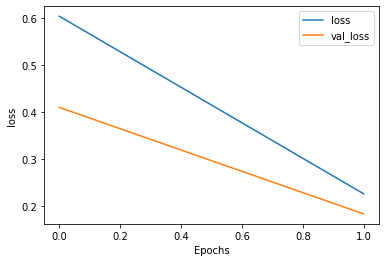

In [8]:
plot_graphs(history, 'loss')

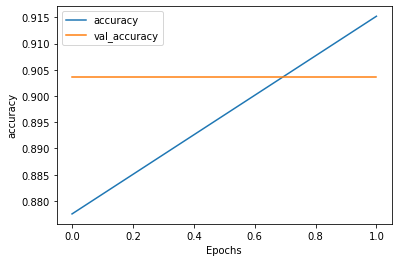

In [9]:
plot_graphs(history, 'accuracy')

In [10]:
testInput = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
testInput = pad_sequences(testInput, maxlen=testInput.shape[1])
testLabelData = np.load(open(DATA_IN_PATH + TEST_LABEL_DATA, 'rb'))

model.load_weights(os.path.join(DATA_OUT_PATH, modelName, SAVE_FILE_NM))
model.evaluate(testInput, testLabelData)

12/12 [==============================] - 0s 7ms/step - loss: 0.3929 - accuracy: 0.8901


[0.39291664958000183, 0.8901408314704895]

In [11]:
print('야호')

data = request.get_json(force=True)
prediction = model.predict([[np.array(data['exp'])]])
output = prediction[0]


야호
